In [1]:
pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.4 MB/s eta 0:00:00


In [2]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.9 MB/s eta 0:00:00


In [3]:
pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16165 sha256=b40908240e23e271b71a134f01aa8942e440eeaa1eed484423e43f04b46af9f9
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [5]:
pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 6.0 MB/s eta 0:00:00


In [2]:
import datasets 
import numpy as np 
from transformers import BertTokenizerFast 
from transformers import DataCollatorForTokenClassification 
from transformers import AutoModelForTokenClassification 
from transformers import TrainingArguments, Trainer 

conll2003 = datasets.load_dataset("conll2003") 

  0%|          | 0/3 [00:00<?, ?it/s]

The function "tokenize_and_align_labels" performs two tasks:

1. It assigns the label "-100" to special tokens and subwords that need to be masked during training.
2. It masks the subword representations after the first subword.

Afterwards, the function aligns the labels with the corresponding token IDs using the chosen strategy.

In [3]:
def tokenize_and_align_labels(examples, label_all_tokens=True): 
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True) 
    labels = [] 
    for i, label in enumerate(examples["ner_tags"]): 
        word_ids = tokenized_inputs.word_ids(batch_index=i) 

        previous_word_idx = None 
        label_ids = []

        for word_idx in word_ids: 
            if word_idx is None: 
                # set –100 as the label for special tokens
                label_ids.append(-100)

            elif word_idx != previous_word_idx:               
                label_ids.append(label[word_idx]) 
            else: 
                label_ids.append(label[word_idx] if label_all_tokens else -100) 
                 
            previous_word_idx = word_idx 
        labels.append(label_ids) 
    tokenized_inputs["labels"] = labels 
    return tokenized_inputs 

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased") 
tokenized_datasets = conll2003.map(tokenize_and_align_labels, batched=True)

In [8]:
# Model
model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels=9)

data_collator = DataCollatorForTokenClassification(tokenizer) 
metric = datasets.load_metric("seqeval") 

args = TrainingArguments( 
"test-ner",
evaluation_strategy = "epoch", 
learning_rate=2e-5, 
per_device_train_batch_size=8, 
per_device_eval_batch_size=8, 
num_train_epochs=4, 
weight_decay=0.01, 
) 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: 

In [9]:
def compute_metrics(eval_preds): 
    pred_logits, labels = eval_preds 
    label_list = conll2003["train"].features["ner_tags"].feature.names
    pred_logits = np.argmax(pred_logits, axis=2) 

    predictions = [ 
        [label_list[eval_preds] for (eval_preds, l) in zip(prediction, label) if l != -100] 
        for prediction, label in zip(pred_logits, labels) 
    ] 
    
    true_labels = [ 
      [label_list[l] for (eval_preds, l) in zip(prediction, label) if l != -100] 
       for prediction, label in zip(pred_logits, labels) 
   ] 
    results = metric.compute(predictions=predictions, references=true_labels)

    return { 
          "precision": results["overall_precision"], 
          "recall": results["overall_recall"], 
          "f1": results["overall_f1"], 
          "accuracy": results["overall_accuracy"], 
  }

In [10]:
trainer = Trainer( 
   model, 
   args, 
   train_dataset=tokenized_datasets["train"], 
   eval_dataset=tokenized_datasets["validation"], 
   data_collator=data_collator, 
   tokenizer=tokenizer, 
   compute_metrics=compute_metrics 
) 

In [11]:
trainer.train() 

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.078700,0.059795,0.928691,0.933885,0.931281,0.984050
2,0.036600,0.058711,0.940517,0.948093,0.944290,0.986369
3,0.018100,0.061739,0.940064,0.951001,0.945501,0.986481
4,0.011800,0.064148,0.944808,0.951784,0.948284,0.986973


TrainOutput(global_step=7024, training_loss=0.0522012883619085, metrics={'train_runtime': 856.6748, 'train_samples_per_second': 65.56, 'train_steps_per_second': 8.199, 'total_flos': 1193409644515488.0, 'train_loss': 0.0522012883619085, 'epoch': 4.0})

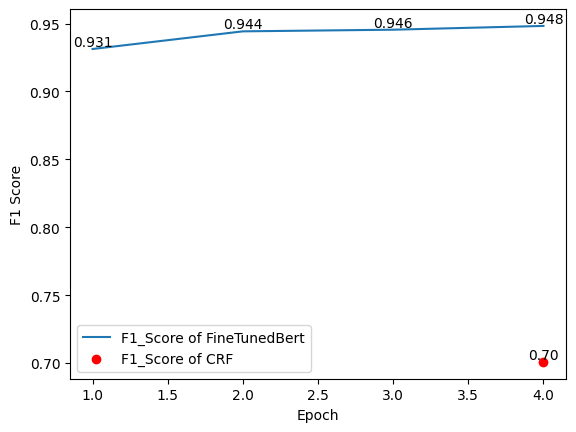

In [22]:
import matplotlib.pyplot as plt
import numpy as np

epochs = [1, 2, 3, 4]
f1_score = [0.931281, 0.944290, 0.945501, 0.948284]

plt.figure()
plt.plot(epochs, f1_score, label='F1_Score of FineTunedBert')
plt.scatter(4, 0.7008, color='red', label='F1_Score of CRF')
plt.text(4,  0.7008, f'{ 0.7008:.2f}', verticalalignment='bottom', horizontalalignment='center')
for i, score in enumerate(f1_score):
    plt.text(epochs[i], score, f'{score:.3f}', verticalalignment='bottom', horizontalalignment='center')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()